In [3]:
# import the imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# in case we want to cluser again
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

pl2024 = pd.read_csv('pl_2024.csv')
pl2023 = pd.read_csv('pl_2023.csv')
pl2022 = pd.read_csv('pl_2022.csv')

In [4]:
# show the data
pl2024.sample(2)

,Div,Date,Time,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,...,B365CAHH,B365CAHA,PCAHH,PCAHA,MaxCAHH,MaxCAHA,AvgCAHH,AvgCAHA,BFECAHH,BFECAHA
301,E0,05/04/2025,15:00,Ipswich,Wolves,1,2,A,1,0,...,2.03,1.90,2.02,1.91,2.06,1.91,2.01,1.87,2.07,1.92
369,E0,20/05/2025,20:00,Man City,Bournemouth,3,1,H,2,0,...,1.95,1.95,1.96,1.96,1.96,2.00,1.92,1.93,2.00,1.99


## Following On From Yesterday 

Let's try make a mega table, there are not the same amount of columns for the older datasetes but it looks like they share all the same ones. 

Let's see how the table looks over the past 3 years. 

In [5]:
# label each season before combining
pl2022['Season'] = '2022'
pl2023['Season'] = '2023'
pl2024['Season'] = '2024'

# combine all three seasons
all_seasons = pd.concat([pl2022, pl2023, pl2024], ignore_index=True)

# get all unique teams
teams = pd.concat([all_seasons['HomeTeam'], all_seasons['AwayTeam']]).unique()

# Initialize combined mega table
mega_table = pd.DataFrame(0, index=teams, columns=["P", "W", "D", "L", "GF", "GA", "GD", "Pts", "SeasonsPlayed"])

# Build the table
for _, row in all_seasons.iterrows():
    home = row["HomeTeam"]
    away = row["AwayTeam"]
    hg, ag = row["FTHG"], row["FTAG"]
    result = row["FTR"]
    season = row["Season"]

    # Home stats
    mega_table.loc[home, "P"] += 1
    mega_table.loc[home, "GF"] += hg
    mega_table.loc[home, "GA"] += ag
    if result == "H":
        mega_table.loc[home, "W"] += 1
        mega_table.loc[home, "Pts"] += 3
    elif result == "D":
        mega_table.loc[home, "D"] += 1
        mega_table.loc[home, "Pts"] += 1
    else:
        mega_table.loc[home, "L"] += 1

    # Away stats
    mega_table.loc[away, "P"] += 1
    mega_table.loc[away, "GF"] += ag
    mega_table.loc[away, "GA"] += hg
    if result == "A":
        mega_table.loc[away, "W"] += 1
        mega_table.loc[away, "Pts"] += 3
    elif result == "D":
        mega_table.loc[away, "D"] += 1
        mega_table.loc[away, "Pts"] += 1
    else:
        mega_table.loc[away, "L"] += 1

# Compute GD
mega_table["GD"] = mega_table["GF"] - mega_table["GA"]

# Count how many seasons each club appeared in
season_counts = all_seasons[["HomeTeam", "Season"]].drop_duplicates().groupby("HomeTeam")["Season"].nunique()
mega_table["SeasonsPlayed"] = mega_table.index.map(season_counts).fillna(0).astype(int)

# Optional: Points per season
mega_table["AvgPts"] = (mega_table["Pts"] / mega_table["SeasonsPlayed"]).round(2)

# Final sort
mega_table = mega_table.sort_values(by=["Pts", "GD", "GF"], ascending=False)

# View
display(mega_table)


,P,W,D,L,GF,GA,GD,Pts,SeasonsPlayed,AvgPts
Man City,114,77,20,17,262,111,151,251,3,83.67
Arsenal,114,74,25,15,248,106,142,247,3,82.33
Liverpool,114,68,29,17,247,129,118,233,3,77.67
Newcastle,114,57,26,31,221,142,79,197,3,65.67
Aston Villa,114,57,24,33,185,158,27,195,3,65.00
Man United,114,52,21,41,159,155,4,177,3,59.00
Chelsea,114,49,29,36,179,153,26,176,3,58.67
Brighton,114,46,33,35,193,174,19,171,3,57.00
Tottenham,114,49,17,48,208,189,19,164,3,54.67
Brentford,114,41,31,42,180,168,12,154,3,51.33


## Anddddd it works. 

Great, we will style this up, but good to see it works and we can see who has performed the best over this time. 

In [6]:
# let's borrow our stylish table from yesterday --  have to change final table to mega_table
final_table = mega_table.copy()
def sort_final_table(by: str = "Pts", ascending: bool = False):
    """
    Return the league table sorted by any column.
    
    Args:
        by (str): Column name to sort by.
        ascending (bool): Sort order; use True for ascending.

    Returns:
        pd.DataFrame: Sorted league table.
    """
    if by not in final_table.columns:
        raise ValueError(f"Column '{by}' not found in table.")

    return final_table.sort_values(by=by, ascending=ascending)

def style_final_table(df, color_by="Pts"):
    styled = (
        df.style
        .background_gradient(subset=[color_by], cmap="RdYlGn", axis=0)
        .format("{:.0f}")
        .set_caption("Premier League 2024 Final Table")
        .set_table_styles([
            {"selector": "th.row_heading", "props": [("font-size", "14pt"), ("font-weight", "bold"), ("color", "#D7BC37")]},
            {"selector": "caption", "props": [("caption-side", "top"), ("font-size", "16pt"), ("font-weight", "bold")]}
        ])
    )
    return styled

In [7]:
display(style_final_table(sort_final_table(by="D"), color_by="Pts"))

,P,W,D,L,GF,GA,GD,Pts,SeasonsPlayed,AvgPts
Everton,114,32,36,46,116,152,-36,132,3,44
Crystal Palace,114,37,36,41,148,158,-10,147,3,49
Brighton,114,46,33,35,193,174,19,171,3,57
Brentford,114,41,31,42,180,168,12,154,3,51
Chelsea,114,49,29,36,179,153,26,176,3,59
Liverpool,114,68,29,17,247,129,118,233,3,78
Nott'm Forest,114,37,28,49,145,181,-36,139,3,46
West Ham,114,36,27,51,148,191,-43,135,3,45
Newcastle,114,57,26,31,221,142,79,197,3,66
Bournemouth,114,39,26,49,149,184,-35,143,3,48


In [8]:
# Again borrow from yesterday so we can look at some stats over time: 
# final table is going to have winning and winless streaks
from collections import defaultdict

# === Your Original Table Logic ===
teams = pd.concat([all_seasons["HomeTeam"], all_seasons["AwayTeam"]]).unique()
table = pd.DataFrame(0, index=teams, columns=[
    "P", "W", "D", "L", "GF", "GA", "GD", "Pts",
    "HomeGoals", "AwayGoals", "TotalFouls", "TotalShots", "TotalYellows", "HomeVSAwayGoals"
])

for _, row in all_seasons.iterrows():
    home, away = row["HomeTeam"], row["AwayTeam"]
    hg, ag = row["FTHG"], row["FTAG"]
    result = row["FTR"]

    table.loc[home, ["P", "GF", "GA", "HomeGoals"]] += [1, hg, ag, hg]
    table.loc[away, ["P", "GF", "GA", "AwayGoals"]] += [1, ag, hg, ag]

    if result == "H":
        table.loc[home, "W"] += 1
        table.loc[home, "Pts"] += 3
        table.loc[away, "L"] += 1
    elif result == "D":
        table.loc[home, "D"] += 1
        table.loc[away, "D"] += 1
        table.loc[[home, away], "Pts"] += 1
    else:
        table.loc[away, "W"] += 1
        table.loc[away, "Pts"] += 3
        table.loc[home, "L"] += 1

    table.loc[home, "TotalFouls"] += row.get("HF", 0)
    table.loc[away, "TotalFouls"] += row.get("AF", 0)
    table.loc[home, "TotalShots"] += row.get("HS", 0)
    table.loc[away, "TotalShots"] += row.get("AS", 0)
    table.loc[home, "TotalYellows"] += row.get("HY", 0)
    table.loc[away, "TotalYellows"] += row.get("AY", 0)

table["GD"] = table["GF"] - table["GA"]
table["HomeVSAwayGoals"] = table["HomeGoals"] - table["AwayGoals"]

# === Add Streaks ===
# Sort matches chronologically
data_sorted = all_seasons.sort_values("Date")
team_results = defaultdict(list)

for _, row in data_sorted.iterrows():
    home, away, result = row["HomeTeam"], row["AwayTeam"], row["FTR"]
    team_results[home].append("W" if result == "H" else "D" if result == "D" else "L")
    team_results[away].append("W" if result == "A" else "D" if result == "D" else "L")

def get_streak(seq, win=True):
    best = count = 0
    for res in seq:
        if (win and res == "W") or (not win and res != "W"):
            count += 1
            best = max(best, count)
        else:
            count = 0
    return best

def get_undefeated_streak(seq):
    best = count = 0
    for res in seq:
        if res != "L":
            count += 1
            best = max(best, count)
        else:
            count = 0
    return best

# Add to table
table["UndefeatedStreak"] = [get_undefeated_streak(team_results[team]) for team in table.index]

# Compute and assign streaks
table["WinStreak"] = [get_streak(team_results[team], win=True) for team in table.index]
table["NoWinStreak"] = [get_streak(team_results[team], win=False) for team in table.index]

# Final table sort and cast
final_table = table.sort_values(by=["Pts", "GD", "GF"], ascending=False).astype(int)


In [9]:
display(style_final_table(sort_final_table(by="UndefeatedStreak"), color_by="Pts"))

,P,W,D,L,GF,GA,GD,Pts,HomeGoals,AwayGoals,TotalFouls,TotalShots,TotalYellows,HomeVSAwayGoals,UndefeatedStreak,WinStreak,NoWinStreak
Liverpool,114,68,29,17,247,129,118,233,137,110,1297,2043,186,27,19,6,7
Man City,114,77,20,17,262,111,151,251,154,108,921,1900,151,46,16,10,3
Arsenal,114,74,25,15,248,106,142,247,136,112,1164,1797,177,24,15,7,3
Newcastle,114,57,26,31,221,142,79,197,125,96,1185,1646,201,29,11,5,6
Brighton,114,46,33,35,193,174,19,171,97,96,1278,1707,220,1,10,4,9
Brentford,114,41,31,42,180,168,12,154,104,76,1057,1311,205,28,10,4,10
Crystal Palace,114,37,36,41,148,158,-10,147,82,66,1319,1397,222,16,10,4,10
Aston Villa,114,57,24,33,185,158,27,195,115,70,1236,1429,246,45,9,5,6
Bournemouth,114,39,26,49,149,184,-35,143,70,79,1411,1477,245,-9,9,3,9
Man United,114,52,21,41,159,155,4,177,90,69,1234,1669,241,21,8,7,4


## Nice To See A Beautiful Table

Here I have ordered it by the longest undefeated streak. By using the styling option for a Bright & Big Yellow Name for the club and their points overtime when you reorder the list, you can see its impact. It's also interesting what this allows, by only changing one element we can see a drastically different table. 

Also really interesting to see that Undefeated Streak shows Brighton and Brentfod come up really high, and Tottenham as the lowest for a team with 3 full seasons. 

Let's now look at making a graph to show the top 3 over the past three seasons

In [16]:
# very nice, let's look at making a graph to show the top 3 over the past three seasons
# make sure the date is in datetime format
all_seasons["Date"] = pd.to_datetime(all_seasons["Date"], errors="coerce", dayfirst=True)
all_seasons = all_seasons.sort_values("Date")
top_teams = final_table.index[:3].tolist()

# Initialize tracker
team_points = {team: [] for team in top_teams}
cumulative = {team: 0 for team in top_teams}
matchweeks = []

# Loop through each matchday
for _, row in all_seasons.iterrows():
    home, away, result = row["HomeTeam"], row["AwayTeam"], row["FTR"]
    week = row["Date"]

    # Track matchweek only if one of top teams involved
    for team in top_teams:
        if team in [home, away]:
            matchweeks.append(week)

            # Points earned
            if team == home:
                if result == "H": pts = 3
                elif result == "D": pts = 1
                else: pts = 0
            elif team == away:
                if result == "A": pts = 3
                elif result == "D": pts = 1
                else: pts = 0
            else:
                pts = 0

            cumulative[team] += pts
            team_points[team].append((week, cumulative[team]))


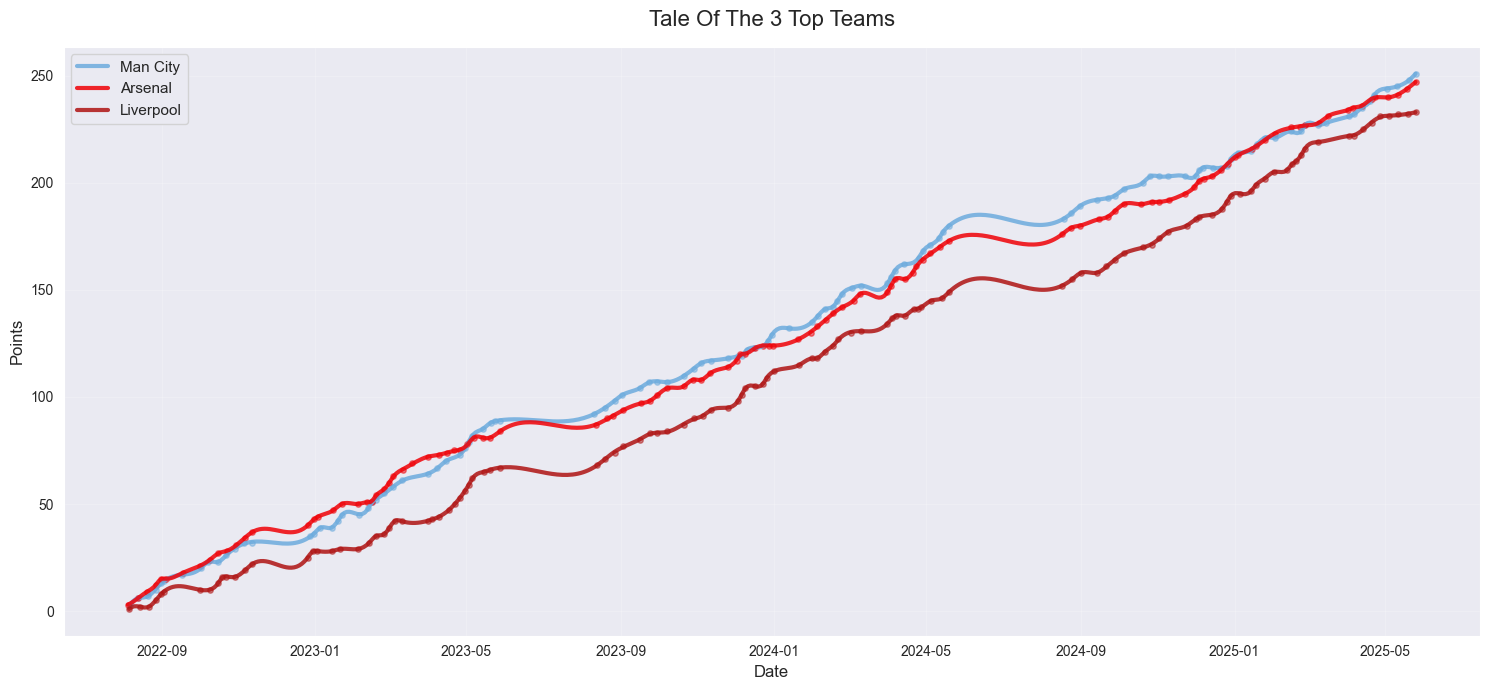

In [17]:
import scipy.interpolate as interp
import matplotlib.dates as mdates

plt.figure(figsize=(15, 7))
sns.set_style("dark")
team_colors = {
    'Man City': '#6CABDD',  # Sky blue
    'Arsenal': '#EF0107',   # Arsenal red
    'Liverpool': "#AF1313FB"  # Liverpool green (alternative)
}

# Plot each team with clean styling
for team, points in team_points.items():
    dates, cum_pts = zip(*points)
    
    # convert dates to allow for a smoother curve
    date_nums = mdates.date2num(dates)
    tck = interp.splrep(date_nums, cum_pts, s=3)
    xnew = np.linspace(date_nums.min(), date_nums.max(), 500)
    ynew = interp.splev(xnew, tck)
    
    # Plot the smooth line
    plt.plot(mdates.num2date(xnew), ynew, 
             label=team, 
             linewidth=3.0,
             color=team_colors.get(team),
             alpha=0.85)
    
    # Plot the actual data points with small markers
    plt.scatter(dates, cum_pts, s=15, color=team_colors.get(team), alpha=0.5)

# Clean, minimal title and labels
plt.title("Tale Of The 3 Top Teams", fontsize=16, pad=15)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Points", fontsize=12)

# Subtle grid for reference without distraction
plt.grid(True, linestyle='-', linewidth=0.5, alpha=0.3)

# Simple legend positioning
plt.legend(loc='upper left', frameon=True, fontsize=11)

# Clean tick labels
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.tight_layout()
plt.show()

## Which Team Missed Out ?

Liverpool Surely ? The one hanging way back consistently behind them ? No again. 

This really highlights how consistently well Aresnal have been performing leading one to think that they are basically unlucky. 

You can see smaller trends too, like how Liverpool were "At The Beach" at the end of their title winning campaign where that line flattens out, you can also make out Man City struggles last season too as it is basically flat as Arsenal continues a relatively steady climb. 

It's a cool graph, but let's customise and standardise a bit so we can see more teams and more metrics. Like 5 teams and Total Shots. 

In [18]:
# === Settings ===
metric = "Points"           # Change to: "Goals", "Fouls", "YellowCards", "Points", etc.
top_n = 10                  # Number of teams to show
title_label = f"Cumulative {metric} Over Time (Top {top_n})"

# === Choose metric function ===
def get_metric_points(df, teams, kind):
    tracker = {team: [] for team in teams}
    cumulative = {team: 0 for team in teams}

    for _, row in df.iterrows():
        home, away, result = row["HomeTeam"], row["AwayTeam"], row["FTR"]
        date = row["Date"]

        if kind == "Goals":
            if home in tracker:
                cumulative[home] += row.get("FTHG", 0)
                tracker[home].append((date, cumulative[home]))
            if away in tracker:
                cumulative[away] += row.get("FTAG", 0)
                tracker[away].append((date, cumulative[away]))

        elif kind == "Fouls":
            if home in tracker:
                cumulative[home] += row.get("HF", 0)
                tracker[home].append((date, cumulative[home]))
            if away in tracker:
                cumulative[away] += row.get("AF", 0)
                tracker[away].append((date, cumulative[away]))

        elif kind == "YellowCards":
            if home in tracker:
                cumulative[home] += row.get("HY", 0)
                tracker[home].append((date, cumulative[home]))
            if away in tracker:
                cumulative[away] += row.get("AY", 0)
                tracker[away].append((date, cumulative[away]))

        elif kind == "Points":
            for team in [home, away]:
                if team not in tracker: continue
                pts = 0
                if team == home:
                    pts = 3 if result == "H" else 1 if result == "D" else 0
                elif team == away:
                    pts = 3 if result == "A" else 1 if result == "D" else 0
                cumulative[team] += pts
                tracker[team].append((date, cumulative[team]))
        
        elif kind == "TotalShots":
            if home in tracker:
                cumulative[home] += row.get("HS", 0)
                tracker[home].append((date, cumulative[home]))
            if away in tracker:
                cumulative[away] += row.get("AS", 0)
                tracker[away].append((date, cumulative[away]))
    return tracker


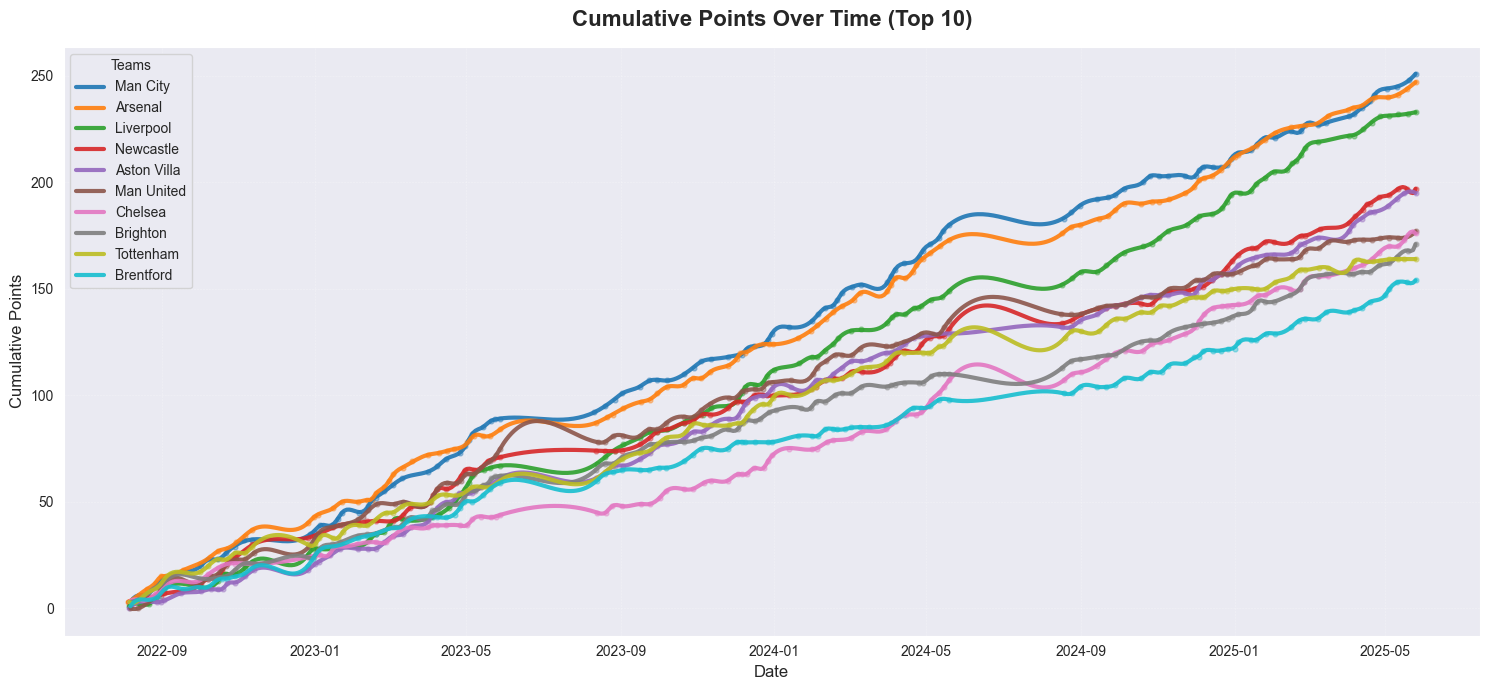

In [19]:
metric_col_map = {
    "Goals": "GF",
    "Fouls": "TotalFouls",
    "YellowCards": "TotalYellows",
    "Points": "Pts",
    "TotalShots": "TotalShots"
}

# Get top teams based on the relevant column in final_table
stat_col = metric_col_map[metric]
top_teams = final_table.sort_values(by=stat_col, ascending=False).head(top_n).index.tolist()

# Get cumulative metric history
team_points = get_metric_points(all_seasons, top_teams, metric)

# === Plotting ===
plt.figure(figsize=(15, 7))
sns.set_style("darkgrid")

# Color palette
palette = sns.color_palette("tab10", n_colors=top_n)
team_colors = dict(zip(top_teams, palette))

for team, points in team_points.items():
    dates, values = zip(*points)
    date_nums = mdates.date2num(dates)

    # Smooth spline
    tck = interp.splrep(date_nums, values, s=3)
    xnew = np.linspace(date_nums.min(), date_nums.max(), 500)
    ynew = interp.splev(xnew, tck)

    plt.plot(mdates.num2date(xnew), ynew, label=team,
             color=team_colors.get(team), linewidth=3, alpha=0.9)
    plt.scatter(dates, values, s=12, color=team_colors.get(team), alpha=0.4)

# Labels and title
plt.title(title_label, fontsize=16, weight="bold", pad=15)
plt.xlabel("Date", fontsize=12)
plt.ylabel(f"Cumulative {metric}", fontsize=12)
plt.legend(title="Teams", fontsize=10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(True, linestyle="--", linewidth=0.4, alpha=0.4)
plt.tight_layout()
plt.show()


# Key Insights and Applications from Premier League Analysis

## Core Takeaways

1. **Persistence Trumps Momentary Form**: The multi-season analysis reveals how consistently high-performing teams (Manchester City, Arsenal) maintain their position at the top of the table across seasons, despite occasional slumps. This long-term view provides a much clearer picture of team quality than single-season snapshots.

2. **Performance Beyond Points**: Our analysis of metrics like undefeated streaks and total shots demonstrates that the traditional league table only tells part of the story. Teams like Brighton and Brentford show surprising resilience with long undefeated streaks despite not finishing at the top of the table.

3. **Data Visualization Reveals Hidden Patterns**: The smoothed trajectory plots highlight periods where teams "switched off" (Liverpool flattening at the end of their campaign) or struggled (Manchester City's plateau while Arsenal climbed steadily). These subtle patterns are often missed in traditional tabular data.

4. **Statistical Consistency vs. Results**: Arsenal's consistent performance across multiple metrics suggests they may have been "unlucky" not to win a title during this period, highlighting the gap between statistical performance and actual results.

## Broader Applications

This analytical approach has applications well beyond football:
 
- **Investment Analysis**: The smoothed curve approach could visualize portfolio performance against benchmarks, highlighting periods of over/underperformance

- **Product Development**: Comparing product metrics (user engagement, retention) across similar products over time would reveal which have sustainable growth versus flash-in-the-pan success

## Further Analysis Opportunity: Expected vs. Actual Performance

A fascinating next step would be to create an "expected points" model based on underlying performance metrics (shots, possession, xG) to determine which teams consistently overperform or underperform their statistical indicators. This would involve:

1. Identifying teams with significant positive or negative variance
2. Analyzing whether these variances persist season-to-season (suggesting tactical approach) or regress to the mean (suggesting luck)

This analysis would potentially reveal which teams have sustainable success strategies versus those benefiting from temporary good fortune, providing deeper insights into long-term competitive advantage in professional football.